# Architecture Test: Can 6/6/384 Actually Learn?

Testing the nanoGPT/TinyStories recommended architecture:
- 6 layers, 6 heads, 384 dim
- Proper training: warmup, AdamW betas (0.9, 0.95), cosine decay, dropout=0.0

Goals:
1. Does loss drop below 6.75? (our pathological floor)
2. What's our steps/sec? (speed budget)
3. Can it generate anything other than "the the the"?

---

*Jeffery Harrell & Alpha, December 1, 2025*

## Setup

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file, save_file
from tokenizers import Tokenizer
import json
import time
import math
import numpy as np
from tqdm.auto import tqdm

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [18]:
# === Parameters ===

# Paths
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture: nanoGPT/TinyStories recommended
N_LAYERS = 6        # was 4
D_MODEL = 384       # was 128
N_HEADS = 6         # was 2
D_FF = 1536         # 4× D_MODEL (standard ratio)
SEQ_LEN = 128
DROPOUT = 0.0       # no dropout for tiny models

# Training: fixed per research
BATCH_SIZE = 2
LEARNING_RATE = 1e-3
WARMUP_STEPS = 100
NUM_STEPS = 10_000
MIN_LR = 1e-4       # cosine decay floor (10% of peak)
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.95) # GPT-2/3 standard, NOT PyTorch default

MODEL_DTYPE = torch.bfloat16
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

## Load Data

In [19]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = set(census['dead_token_ids'])
print(f"✓ Dead tokens: {len(dead_token_ids):,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914


## Dataset & Model

In [20]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Dataset: 100,000 samples


In [21]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight  # Weight tying
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
        self._init_weights()
    
    def _init_weights(self):
        """N(0, 0.02) for token embeddings — matches Qwen/GPT-2."""
        with torch.no_grad():
            self.tok_emb.weight.copy_(torch.randn(self.tok_emb.weight.shape) * 0.02)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))

model = GPT(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    seq_len=SEQ_LEN,
    dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model: {n_params:,} parameters ({n_params/1e6:.1f}M)")
print(f"  Architecture: {N_LAYERS}L / {N_HEADS}H / {D_MODEL}D")

✓ Model: 12,228,096 parameters (12.2M)
  Architecture: 6L / 6H / 384D


In [22]:
# Optimizer with correct betas
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=BETAS,
    weight_decay=WEIGHT_DECAY
)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE}, betas={BETAS}, wd={WEIGHT_DECAY})")
print(f"✓ Warmup: {WARMUP_STEPS} steps")
print(f"✓ LR schedule: cosine decay to {MIN_LR}")

✓ Optimizer: AdamW (lr=0.001, betas=(0.9, 0.95), wd=0.01)
✓ Warmup: 100 steps
✓ LR schedule: cosine decay to 0.0001


In [23]:
def get_lr(step):
    """Learning rate schedule: linear warmup, then cosine decay."""
    if step < WARMUP_STEPS:
        # Linear warmup
        return LEARNING_RATE * (step + 1) / WARMUP_STEPS
    else:
        # Cosine decay
        decay_steps = NUM_STEPS - WARMUP_STEPS
        progress = (step - WARMUP_STEPS) / decay_steps
        return MIN_LR + 0.5 * (LEARNING_RATE - MIN_LR) * (1 + math.cos(math.pi * progress))

# Quick sanity check
print(f"LR at step 0: {get_lr(0):.6f}")
print(f"LR at step {WARMUP_STEPS}: {get_lr(WARMUP_STEPS):.6f}")
print(f"LR at step {NUM_STEPS//2}: {get_lr(NUM_STEPS//2):.6f}")
print(f"LR at step {NUM_STEPS-1}: {get_lr(NUM_STEPS-1):.6f}")

LR at step 0: 0.000010
LR at step 100: 0.001000
LR at step 5000: 0.000557
LR at step 9999: 0.000100


## Training

In [24]:
model.train()
loader_iter = iter(loader)
losses = []

print(f"Training {NUM_STEPS:,} steps...")
print(f"Interrupt if this takes too long!")
print()

start_time = time.time()

for step in tqdm(range(NUM_STEPS)):
    # Get batch
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    # Update learning rate
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Forward/backward
    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # Progress update every 500 steps
    if (step + 1) % 500 == 0:
        elapsed = time.time() - start_time
        steps_per_sec = (step + 1) / elapsed
        avg_loss = np.mean(losses[-100:])  # last 100 steps
        tqdm.write(f"Step {step+1:,}: loss={avg_loss:.4f}, lr={lr:.6f}, {steps_per_sec:.1f} steps/sec")

elapsed = time.time() - start_time
steps_per_sec = NUM_STEPS / elapsed

print()
print(f"Done! {NUM_STEPS:,} steps in {elapsed:.1f}s")
print(f"Speed: {steps_per_sec:.1f} steps/sec")
print(f"Final loss (avg last 100): {np.mean(losses[-100:]):.4f}")

Training 10,000 steps...
Interrupt if this takes too long!



  0%|          | 0/10000 [00:00<?, ?it/s]

Step 500: loss=6.8206, lr=0.000996, 68.5 steps/sec
Step 1,000: loss=6.8028, lr=0.000982, 67.4 steps/sec
Step 1,500: loss=6.8050, lr=0.000956, 67.2 steps/sec
Step 2,000: loss=6.7753, lr=0.000921, 67.5 steps/sec
Step 2,500: loss=6.7919, lr=0.000876, 67.7 steps/sec
Step 3,000: loss=6.7794, lr=0.000823, 67.8 steps/sec
Step 3,500: loss=6.7891, lr=0.000763, 68.0 steps/sec
Step 4,000: loss=6.7847, lr=0.000697, 68.0 steps/sec
Step 4,500: loss=6.7713, lr=0.000628, 68.1 steps/sec
Step 5,000: loss=6.7819, lr=0.000557, 68.1 steps/sec
Step 5,500: loss=6.7869, lr=0.000486, 68.2 steps/sec
Step 6,000: loss=6.7591, lr=0.000417, 68.2 steps/sec
Step 6,500: loss=6.7538, lr=0.000350, 68.3 steps/sec
Step 7,000: loss=6.7472, lr=0.000289, 68.3 steps/sec
Step 7,500: loss=6.7512, lr=0.000234, 68.3 steps/sec
Step 8,000: loss=6.7469, lr=0.000188, 68.4 steps/sec
Step 8,500: loss=6.7666, lr=0.000150, 68.3 steps/sec
Step 9,000: loss=6.7297, lr=0.000123, 68.3 steps/sec
Step 9,500: loss=6.7297, lr=0.000106, 68.4 steps

## Results

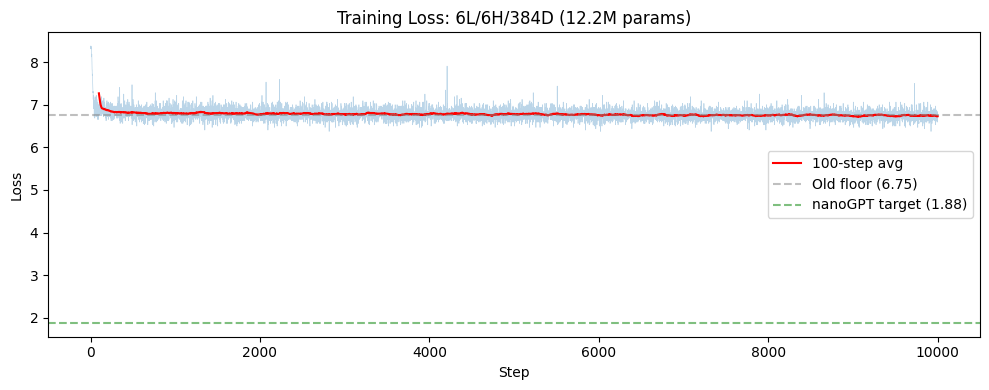

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses, alpha=0.3, linewidth=0.5)

# Smoothed
window = 100
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=1.5, label=f'{window}-step avg')

# Reference lines
ax.axhline(6.75, color='gray', linestyle='--', alpha=0.5, label='Old floor (6.75)')
ax.axhline(1.88, color='green', linestyle='--', alpha=0.5, label='nanoGPT target (1.88)')

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title(f'Training Loss: {N_LAYERS}L/{N_HEADS}H/{D_MODEL}D ({n_params/1e6:.1f}M params)')
ax.legend()
plt.tight_layout()
plt.savefig('04_architecture_test_loss.png', dpi=150)
plt.show()

In [26]:
print("=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Architecture: {N_LAYERS}L / {N_HEADS}H / {D_MODEL}D")
print(f"Parameters: {n_params:,} ({n_params/1e6:.1f}M)")
print(f"Speed: {steps_per_sec:.1f} steps/sec")
print(f"Time for 10K steps: {10000/steps_per_sec/60:.1f} minutes")
print()
print(f"Loss at step 500: {np.mean(losses[400:500]):.4f}")
print(f"Loss at step 1000: {np.mean(losses[900:1000]):.4f}")
print(f"Loss at step 5000: {np.mean(losses[4900:5000]):.4f}" if len(losses) >= 5000 else "(not reached)")
print(f"Final loss: {np.mean(losses[-100:]):.4f}")
print()
print(f"Old Goldilocks floor: 6.75")
print(f"nanoGPT target: ~1.88")
print(f"Did we beat old floor? {'YES' if np.mean(losses[-100:]) < 6.75 else 'NO'}")

SUMMARY
Architecture: 6L / 6H / 384D
Parameters: 12,228,096 (12.2M)
Speed: 68.4 steps/sec
Time for 10K steps: 2.4 minutes

Loss at step 500: 6.8206
Loss at step 1000: 6.8028
Loss at step 5000: 6.7819
Final loss: 6.7303

Old Goldilocks floor: 6.75
nanoGPT target: ~1.88
Did we beat old floor? YES


## Quick Generation Test

In [27]:
@torch.no_grad()
def generate(model, tokenizer, prompt, max_new_tokens=50, temperature=0.8):
    model.eval()
    encoded = tokenizer.encode(prompt)
    tokens = torch.tensor(encoded.ids, dtype=torch.long, device=device).unsqueeze(0)
    
    for _ in range(max_new_tokens):
        tokens_cond = tokens[:, -SEQ_LEN:]
        logits = model(tokens_cond)
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, next_token], dim=1)
    
    return tokenizer.decode(tokens[0].tolist())

print("Generation test (temperature=0.8):")
print("-" * 40)
for prompt in ["The ", "Once upon a time", "In the beginning"]:
    print(f"Prompt: {repr(prompt)}")
    print(generate(model, tokenizer, prompt))
    print()

Generation test (temperature=0.8):
----------------------------------------
Prompt: 'The '
The  exVianim is.comc., appat of Ventlyper-a qu the are not ca Em tore and Thge Amverch ( 12ureds Mes Ourm the", as attcction var thating as

Prompt: 'Once upon a time'
Once upon a time ro outr; and and 2 he, theageesock outaur l Marin an anicction reion the course byp-.10m We wideight, s their sv A is0 fromes the anw a

Prompt: 'In the beginning'
In the beginning toightd oned the we the we at everywe.
 wellame of and power aus s is J current Hill eleestid of Sardle the ex toso stnIed the of people'sartceptm A

